In this script, we pull in the merged ocean basin GLODAP v2 2019 bottle data .mat file (which can be found here https://www.nodc.noaa.gov/archive/arc0107/0162565/2.2/data/0-data/data_product/, and moved onto whatever computer you're working on with a wget command), minimally process it into a .nc xarray friendly format with plenty of metadata, and then save only Southern Ocean measurements (south of 30S) in a separate .nc file. This way you don't have to keep the whole GLODAP library on your system, and you have a python friendly .nc version of the SO data on hand for analysis.

In [1]:
import xarray as xr
import dask.array
import numpy as np
## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import sys
sys.path.append('./supporting_data_files/') 
# above directory function for masking and this is where you should store GLODAPv2.2019_Merged_Master_File.mat (or change filepaths below)
from masking import *
import scipy.io
import matplotlib.path as mpath
import matplotlib.ticker as mticker


In [2]:
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [3]:
# these maps are computed from the bathymetry file of ACCESS-OM2-01, ported from my old computer in Aus
# the contours are continous approximations of 1000 and 3000 m isobaths (3000 isobath is more approximate)
# these are meant to roughly represent the shelf and slope around Antarctica
land_map = access_land_map()

In [4]:
# GLODAP = scipy.io.loadmat('/work/Ruth.Moorman/GLODAP/GLODAPv2.2019_Merged_Master_File.mat') # this is where mine is stored (can use if you're on my computer)
GLODAP = scipy.io.loadmat('./supporting_data_files/GLODAPv2.2019_Merged_Master_File.mat') # use this or define the path to wherever you have this data stored
GLODAP_var_str = ['G2cruise','G2station','G2cast','G2year','G2month','G2day','G2hour','G2minute','G2latitude','G2longitude','G2bottomdepth','G2maxsampdepth','G2bottle','G2pressure','G2depth','G2temperature','G2theta','G2salinity','G2salinityf','G2salinityqc','G2sigma0','G2sigma1','G2sigma2','G2sigma3','G2sigma4','G2gamma','G2oxygen','G2oxygenf','G2oxygenqc','G2aou','G2aouf','G2nitrate','G2nitratef','G2nitrateqc','G2nitrite','G2nitritef','G2silicate','G2silicatef','G2silicateqc','G2phosphate','G2phosphatef','G2phosphateqc','G2tco2','G2tco2f','G2tco2qc','G2talk','G2talkf','G2talkqc','G2phts25p0','G2phts25p0f','G2phtsinsitutp','G2phtsinsitutpf','G2phtsqc','G2cfc11','G2pcfc11','G2cfc11f','G2cfc11qc','G2cfc12','G2pcfc12','G2cfc12f','G2cfc12qc','G2cfc113','G2pcfc113','G2cfc113f','G2cfc113qc','G2ccl4','G2pccl4','G2ccl4f','G2ccl4qc','G2sf6','G2psf6','G2sf6f','G2c13','G2c13f','G2c13qc','G2c14','G2c14f','G2c14err','G2h3','G2h3f','G2h3err','G2he3','G2he3f','G2he3err','G2he','G2hef','G2heerr','G2neon','G2neonf','G2neonerr','G2o18','G2o18f','G2toc','G2tocf','G2doc','G2docf','G2don','G2donf','G2tdn','G2tdnf','G2chla','G2chlaf']
GLODAP_var_str_2 = ['cruise','station','cast','year','month','day','hour','minute','latitude','longitude','bottomdepth','maxsampdepth','bottle','pressure','depth','temperature','theta','salinity','salinityf','salinityqc','sigma0','sigma1','sigma2','sigma3','sigma4','gamma','oxygen','oxygenf','oxygenqc','aou','aouf','nitrate','nitratef','nitrateqc','nitrite','nitritef','silicate','silicatef','silicateqc','phosphate','phosphatef','phosphateqc','tco2','tco2f','tco2qc','talk','talkf','talkqc','phts25p0','phts25p0f','phtsinsitutp','phtsinsitutpf','phtsqc','cfc11','pcfc11','cfc11f','cfc11qc','cfc12','pcfc12','cfc12f','cfc12qc','cfc113','pcfc113','cfc113f','cfc113qc','ccl4','pccl4','ccl4f','ccl4qc','sf6','psf6','sf6f','c13','c13f','c13qc','c14','c14f','c14err','h3','h3f','h3err','he3','he3f','he3err','he','hef','heerr','neon','neonf','neonerr','o18','o18f','toc','tocf','doc','docf','don','donf','tdn','tdnf','chla','chlaf']

In [5]:
# if you're curious, the data is structured like this:
# print(GLODAP)

In [6]:
# just a demonstration of the spatial distribution of cruises and samples
UNIQUE_POS = np.concatenate((GLODAP['G2longitude'], GLODAP['G2latitude']), axis = 1)
UNIQUE_INDEX = np.sort(np.unique(UNIQUE_POS,axis = 0, return_index = True)[1])
UNIQUE_LON = UNIQUE_POS[UNIQUE_INDEX,0]
UNIQUE_LAT = UNIQUE_POS[UNIQUE_INDEX,1]

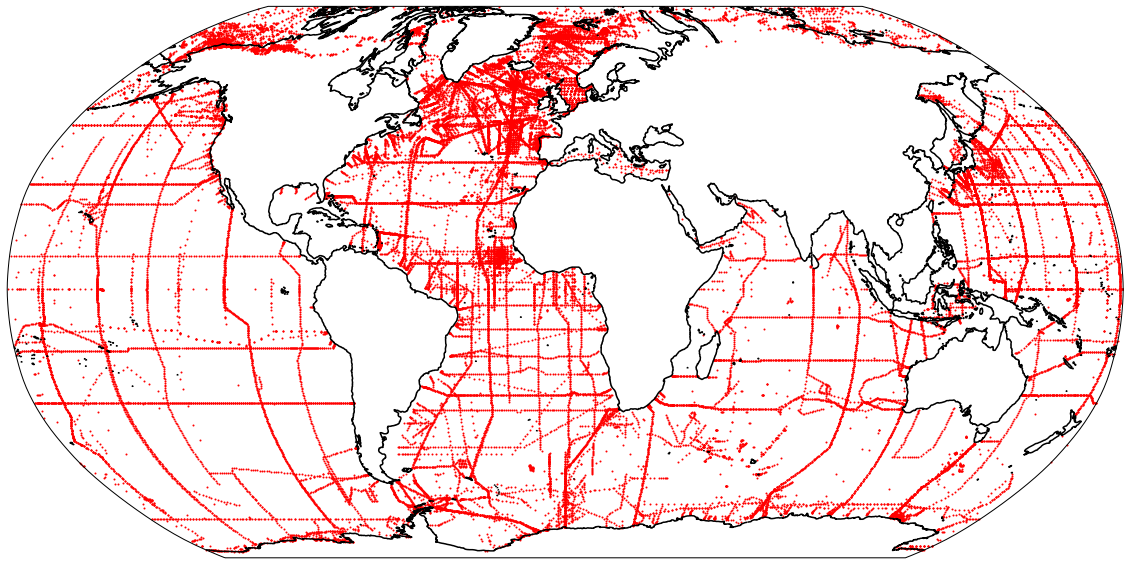

In [7]:
# note: ignore the land mask in the north! I'm gradding a bathymetry files out of a tripole grid ocean model...
# it's just what i had on hand and the mismatch in the arctic is unimportant for our purposes
fig = plt.figure(figsize=[20,12])
ax = plt.subplot(projection = ccrs.Robinson())
ax.contour(land_map.xt_ocean, land_map.yt_ocean,land_map,[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
ax.scatter(UNIQUE_LON, UNIQUE_LAT, s=1, c='r', transform=ccrs.PlateCarree())
plt.show()

In [8]:
SO_LAT = np.where(UNIQUE_LAT<-30, UNIQUE_LAT, np.nan)
SO_LON = UNIQUE_LON * (SO_LAT * 0 + 1)
SO_LAT = SO_LAT[~np.isnan(SO_LAT)] 
SO_LON = SO_LON[~np.isnan(SO_LON)] 

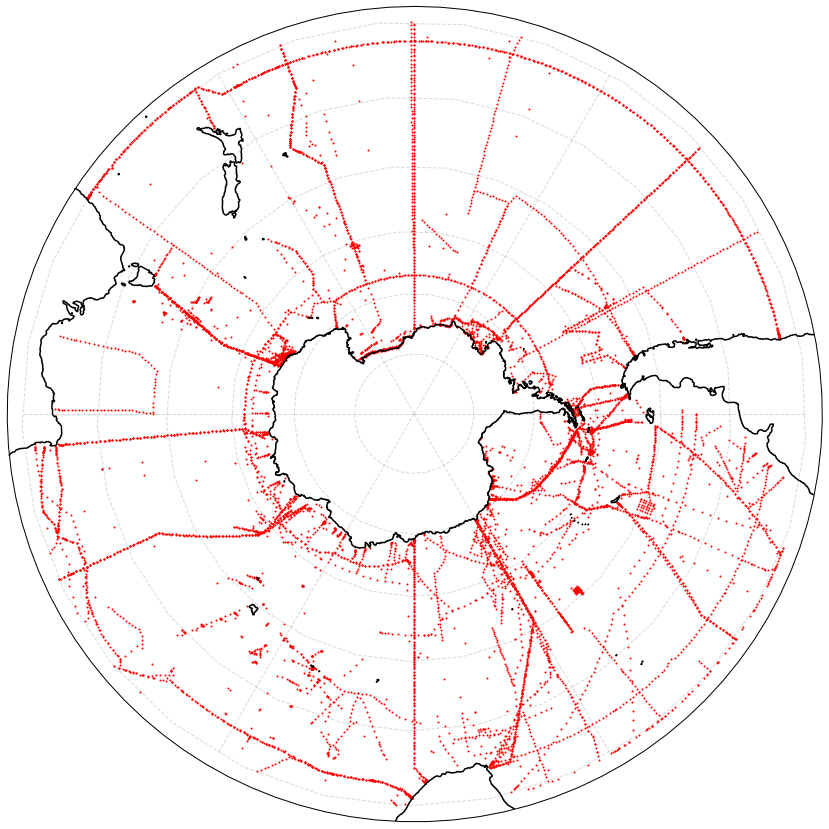

In [9]:
# lets initially plot the non-nan positions to see if it makes sense that these floats would be under ice
fig = plt.figure(figsize=[15, 15])
proj = ccrs.Stereographic(central_longitude=-150,central_latitude=-90)
ax= plt.subplot( projection =proj)
lat_north = -28
ax.set_extent([-180, 180, -90, lat_north], ccrs.PlateCarree())
ax.contour(land_map.sel(yt_ocean = slice(-90,lat_north)).xt_ocean, land_map.sel(yt_ocean = slice(-90,lat_north)).yt_ocean,land_map.sel(yt_ocean = slice(-90,lat_north)),[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
ax.scatter(SO_LON, SO_LAT, s = 1, c = 'r', transform = ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--', alpha = 0.3)
gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50, -40, -30])
plt.show()

In [11]:
# pull out all variables from the .mat file and concatenatue into a simular numpy array (no metadata yet)
GLODAP_ALL_VAR = GLODAP[GLODAP_var_str[0]]
for i in range(1,len(GLODAP_var_str)):
    GLODAP_ALL_VAR = np.concatenate((GLODAP_ALL_VAR, GLODAP[GLODAP_var_str[i]]), axis = 1)

In [12]:
GLODAP_ALL_VAR.shape # all variables combined but with no metadata yet

(1175006, 102)

In [13]:
# we only want samples taken south of 30S
GLODAP_LAT = GLODAP['G2latitude']
GLODAP_SO_LAT = np.where(GLODAP_LAT<-30, GLODAP_LAT, np.nan)
SO_MASK = np.squeeze(GLODAP_SO_LAT * 0 + 1) # creates a mask that can be applied to other variables, 1 for data points 
# with latitude south of 30S, nan for datapoints with latitude north of 30S
GLODAP_SO_LAT = GLODAP_SO_LAT[~np.isnan(GLODAP_SO_LAT)] # just a compressed list of latitudes for the datapoints
# satifying the latitude criteria

In [14]:
# intitialise an empty array containing a row for each latitude point south of 28S and a column for each of the 102 
# variables recorded in GLODAP
SO_ALL_VAR = np.empty((len(GLODAP_SO_LAT),102))

In [15]:
# loop through each of the 102 variables
# masks the data for that variable for only values fulfilling the latitude constraint
# enter SO masked variable data into preapred empty array
for i in range(len(GLODAP_var_str)):
    VAR = np.nan_to_num(GLODAP_ALL_VAR[:,i], nan = 9999999, posinf = 9999999, neginf = 9999999) # in case it already has nan values
    VAR_SO = VAR * SO_MASK
    VAR_SO = VAR_SO[~np.isnan(VAR_SO)]
    VAR_SO[VAR_SO == 9999999] = np.nan
    SO_ALL_VAR[:,i] = VAR_SO

In [16]:
# want a julian time dimension contstructed from the various constituent time columns
years = SO_ALL_VAR[:,3]
months = SO_ALL_VAR[:,4]
days = SO_ALL_VAR[:,5]
hours = SO_ALL_VAR[:,6]
minutes = SO_ALL_VAR[:,7]
time = np.empty((len(GLODAP_SO_LAT)), dtype = 'datetime64[us]')
for i in range(len(time)):
    tstamp = np.datetime64(str(years[i])[:-2], 'Y') + np.timedelta64(str(months[i]-1)[:-2], 'M')+ np.timedelta64(str(days[i]-1)[:-2], 'D')+np.timedelta64(str(hours[i])[:-2], 'h')+np.timedelta64(str(minutes[i])[:-2], 'm')
    time[i] = tstamp

In [17]:
## all the coordinates (not vairbales) must be initially defined as dataarrays before designated as coordinates
INDEX = np.arange(len(GLODAP_SO_LAT))
xcruise = xr.DataArray(SO_ALL_VAR[:,0], coords = [INDEX], dims = 'SAMPLE')
xstation = xr.DataArray(SO_ALL_VAR[:,1], coords = [INDEX], dims = 'SAMPLE')
xcast = xr.DataArray(SO_ALL_VAR[:,2], coords = [INDEX], dims = 'SAMPLE')
xlatitude = xr.DataArray(SO_ALL_VAR[:,8], coords = [INDEX], dims = 'SAMPLE')
xlongitude = xr.DataArray(SO_ALL_VAR[:,9], coords = [INDEX], dims = 'SAMPLE')
xbottomdepth = xr.DataArray(SO_ALL_VAR[:,10], coords = [INDEX], dims = 'SAMPLE')
xmaxsampledepth = xr.DataArray(SO_ALL_VAR[:,11], coords = [INDEX], dims = 'SAMPLE')
xbottle = xr.DataArray(SO_ALL_VAR[:,12], coords = [INDEX], dims = 'SAMPLE')
xpressure = xr.DataArray(SO_ALL_VAR[:,13], coords = [INDEX], dims = 'SAMPLE')
xdepth = xr.DataArray(SO_ALL_VAR[:,14], coords = [INDEX], dims = 'SAMPLE')
xtime = xr.DataArray(time, coords = [INDEX], dims = 'SAMPLE')
xyear = xr.DataArray(SO_ALL_VAR[:,3], coords = [INDEX], dims = 'SAMPLE')
xmonth = xr.DataArray(SO_ALL_VAR[:,4], coords = [INDEX], dims = 'SAMPLE')
xday = xr.DataArray(SO_ALL_VAR[:,5], coords = [INDEX], dims = 'SAMPLE')
xhour = xr.DataArray(SO_ALL_VAR[:,6], coords = [INDEX], dims = 'SAMPLE')
xminute = xr.DataArray(SO_ALL_VAR[:,7], coords = [INDEX], dims = 'SAMPLE')

# pull all variables together into an xarray structure
XR_SO_GLODAP = xr.DataArray(SO_ALL_VAR[:,15:], dims = {'SAMPLE':INDEX,'VARIABLE':GLODAP_var_str_2[15:]}, coords = {'SAMPLE':INDEX,'VARIABLE':GLODAP_var_str_2[15:], 'cruise':xcruise, 'station':xstation,'cast':xcast, 'latitude':xlatitude,'longitude':xlongitude,'time':xtime,'year':xyear,'month':xmonth,'day':xday,'hour':xhour,'minute':'xminute','pressure':xpressure,'depth':xdepth,'bottomdepth':xbottomdepth,'maxsampledepth':xmaxsampledepth,'bottle':xbottle})

In [18]:
# now we have all variables, masked for southern ocean only, and with metadata applied, see below:
XR_SO_GLODAP

<xarray.DataArray (SAMPLE: 278327, VARIABLE: 87)>
array([[-1.282     , -1.2822    , 34.147     , ...,  9.        ,
                nan,  9.        ],
       [        nan,         nan, 34.145     , ...,  9.        ,
                nan,  9.        ],
       [        nan,         nan, 34.138     , ...,  9.        ,
                nan,  9.        ],
       ...,
       [-0.4199    , -0.42501883, 34.4397    , ...,  9.        ,
                nan,  9.        ],
       [-0.3596    , -0.37020744, 34.4862    , ...,  9.        ,
                nan,  9.        ],
       [-0.3729    , -0.38501025, 34.4909    , ...,  9.        ,
                nan,  9.        ]])
Coordinates:
  * SAMPLE          (SAMPLE) int64 0 1 2 3 4 ... 278323 278324 278325 278326
  * VARIABLE        (VARIABLE) <U13 'temperature' 'theta' ... 'chla' 'chlaf'
    cruise          (SAMPLE) float64 2.0 2.0 2.0 ... 1.115e+03 1.115e+03
    station         (SAMPLE) float64 234.0 234.0 234.0 234.0 ... 30.0 30.0 30.0
    cast            (SAMPLE) float64 1.0 1.0 3.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    latitude        (SAMPLE) float64 -58.48 -58.48 -58.48 ... -61.05 -61.05
    longitude       (SAMPLE) float64 -0.99 -0.99 -0.99 ... -54.58 -54.58 -54.58
    time            (SAMPLE) datetime64[ns] 1986-07-17 ... 2016-11-24T04:15:00
    year            (SAMPLE) float64 1.986e+03 1.986e+03 ... 2.016e+03 2.016e+03
    month           (SAMPLE) float64 7.0 7.0 7.0 7.0 7.0 ... 11.0 11.0 11.0 11.0
    day             (SAMPLE) float64 17.0 17.0 17.0 17.0 ... 24.0 24.0 24.0 24.0
    hour            (SAMPLE) float64 0.0 0.0 0.0 0.0 0.0 ... 2.0 4.0 4.0 4.0 4.0
    minute          <U7 'xminute'
    pressure        (SAMPLE) float64 8.8 8.8 15.1 20.0 ... 157.0 306.6 347.3
    depth           (SAMPLE) float64 9.0 9.0 15.0 20.0 ... 155.0 303.0 344.0
    bottomdepth     (SAMPLE) float64 4.769e+03 4.769e+03 ... 357.3 357.3
    maxsampledepth  (SAMPLE) float64 4.76e+03 4.76e+03 4.76e+03 ... 347.3 347.3
    bottle          (SAMPLE) float64 23.0 24.0 24.0 22.0 ... 4.0 3.0 2.0 1.0

In [19]:
# e.g. we can extract temperature data as:
XR_SO_GLODAP.sel(VARIABLE = 'temperature')

<xarray.DataArray (SAMPLE: 278327)>
array([-1.282 ,     nan,     nan, ..., -0.4199, -0.3596, -0.3729])
Coordinates:
  * SAMPLE          (SAMPLE) int64 0 1 2 3 4 ... 278323 278324 278325 278326
    VARIABLE        <U13 'temperature'
    cruise          (SAMPLE) float64 2.0 2.0 2.0 ... 1.115e+03 1.115e+03
    station         (SAMPLE) float64 234.0 234.0 234.0 234.0 ... 30.0 30.0 30.0
    cast            (SAMPLE) float64 1.0 1.0 3.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    latitude        (SAMPLE) float64 -58.48 -58.48 -58.48 ... -61.05 -61.05
    longitude       (SAMPLE) float64 -0.99 -0.99 -0.99 ... -54.58 -54.58 -54.58
    time            (SAMPLE) datetime64[ns] 1986-07-17 ... 2016-11-24T04:15:00
    year            (SAMPLE) float64 1.986e+03 1.986e+03 ... 2.016e+03 2.016e+03
    month           (SAMPLE) float64 7.0 7.0 7.0 7.0 7.0 ... 11.0 11.0 11.0 11.0
    day             (SAMPLE) float64 17.0 17.0 17.0 17.0 ... 24.0 24.0 24.0 24.0
    hour            (SAMPLE) float64 0.0 0.0 0.0 0.0 0.0 ... 2.0 4.0 4.0 4.0 4.0
    minute          <U7 'xminute'
    pressure        (SAMPLE) float64 8.8 8.8 15.1 20.0 ... 157.0 306.6 347.3
    depth           (SAMPLE) float64 9.0 9.0 15.0 20.0 ... 155.0 303.0 344.0
    bottomdepth     (SAMPLE) float64 4.769e+03 4.769e+03 ... 357.3 357.3
    maxsampledepth  (SAMPLE) float64 4.76e+03 4.76e+03 4.76e+03 ... 347.3 347.3
    bottle          (SAMPLE) float64 23.0 24.0 24.0 22.0 ... 4.0 3.0 2.0 1.0

In [20]:
# now save as a dataset structure
ds = xr.Dataset({'Southern_Ocean_GLODAP':XR_SO_GLODAP})
ds.attrs['Details'] = 'All cruise data from south of 30S available from the GLODAPv2.2019 repository (https://www.nodc.noaa.gov/archive/arc0107/0162565/2.2/data/0-data/data_product/)'
# ds.to_netcdf('/work/Ruth.Moorman/GLODAP/GLODAPv2.2019_Southern_Ocean_30S.nc') # this is where mine is stored
ds.to_netcdf('./supporting_data_files/GLODAPv2.2019_Southern_Ocean_30S.nc') # you should use this or defined a preferred path